In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-08-13 09:54:26,968 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-08-13 09:54:26,969 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Load data

In [3]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_exp_library_160ms_with_decoy_pred_20240809_145020_771647/config_20240809_145020_771647.yaml"
ps_dir = "exp_20240809_152440_626269"

In [4]:
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)

In [5]:
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)

mobility_values_df = pd.read_csv(os.path.join(cfg.RESULT_PATH, "mobility_values.csv"))
ms1scans = pd.read_csv(os.path.join(cfg.RESULT_PATH, "ms1scans.csv"))

## Test pred df

In [16]:
test_pred_df = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "results", "test_pred_df.csv"
    )
)

# Generate test set result

In [18]:
cfg.PEAK_SELECTION.MODEL

CfgNode({'TYPE': 'mask_segmentation', 'NAME': 'UNET', 'RESUME_PATH': '', 'PARAMS': CfgNode({'IN_CHANNELS': 3, 'FIRST_OUT_CHANNELS': 32, 'EXIT_CHANNELS': 1, 'DOWNHILL': 4, 'PADDING': 1, 'IMAGE_SIZE': 258}), 'SOLVER': CfgNode({'TOTAL_EPOCHS': 100, 'OPTIMIZER': CfgNode({'BASE_LR': 0.001, 'NAME': 'adam', 'WEIGHT_DECAY': 0, 'SGD': CfgNode({'MOMENTUM': 0.9, 'NESTEROV': False})}), 'SCHEDULER': CfgNode({'NAME': 'one_cycle', 'PATIENCE': 3, 'MIN_LR': 1e-08, 'LR_REDUCE_GAMMA': 0.1, 'FACTOR': 0.1, 'PCT_START': 0.3, 'ANNEAL_STRATEGY': 'cos', 'DIV_FACTOR': 25, 'MAX_LR': 0.01}), 'LOSS': CfgNode({'NAME': 'ComboLoss', 'LOSSTYPES': ['bce', 'wdice', 'dice', 'focal'], 'WEIGHTS': [1, 0, 4, 1], 'CHANNEL_WEIGHTS': [1, 0.5], 'PER_IMAGE': True, 'FOCAL_LOSS': CfgNode({'GAMMA': 1, 'ALPHA': -1})}), 'EARLY_STOPPING': CfgNode({'PATIENCE': 10, 'MODE': 'max'})}), 'EVALUATION': CfgNode({'THRESHOLD': 0.5})})

## Prepare dataset

In [22]:
import torch
from peak_detection_2d.dataset.dataset import (
    build_transformation,
    MultiHDF5_MaskDataset,
)
from peak_detection_2d.model.build_model import build_model

random_state = cfg.RANDOM_SEED
cfg_peak_selection = cfg.PEAK_SELECTION
hdf5_files = cfg_peak_selection.TRAINING_DATA
transformation, cfg_peak_selection.DATASET = build_transformation(
    cfg_peak_selection.DATASET
)
use_hint_channel = "hint" in cfg_peak_selection.DATASET.INPUT_CHANNELS
logging.info("Use hint channel: %s", use_hint_channel)
dataset = MultiHDF5_MaskDataset(
    hdf5_files,
    use_hint_channel=use_hint_channel,
    transforms=transformation,
)
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_VAL_SIZE,
    seed=random_state,
)
train_dataset, val_dataset = train_val_dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_SIZE,
    seed=random_state,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg_peak_selection.DATASET.TRAIN_BATCH_SIZE,
    shuffle=False,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=cfg_peak_selection.DATASET.VAL_BATCH_SIZE, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=cfg_peak_selection.DATASET.TEST_BATCH_SIZE,
    shuffle=False,
)

2024-08-12 09:35:08,686 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f9db4dc4a90>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f9c4b0db0d0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f9c4b0da860>]
2024-08-12 09:35:08,688 - root - INFO - Use hint channel: True


## Prepare model

In [24]:
cfg_model = cfg_peak_selection.MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = os.path.join(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "model_backups",
        "bst_model_0.5668.pt",
    )
)
bst_model = build_model(cfg_model)
checkpoint = torch.load(best_model_path, map_location=device)
bst_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [55]:
import torch

torch.cuda.empty_cache()
import gc

gc.collect()

0

In [56]:
%autoreload 2
from peak_detection_2d.model.seg_model import inference_and_sum_intensity
from peak_detection_2d.loss.custom_loss import (
    per_image_weighted_dice_metric,
    per_image_weighted_iou_metric,
)
from torch.utils.data import Subset

test_subset = Subset(test_dataset, range(1000))
test_subset_dataloader = torch.utils.data.DataLoader(
    test_subset,
    batch_size=32,
    shuffle=False,
)
test_pred_df = inference_and_sum_intensity(
    data_loader=test_subset_dataloader,
    model=bst_model,
    device=device,
    per_image_metric=[per_image_weighted_dice_metric, per_image_weighted_iou_metric],
    use_image_for_metric=[True, True],
                channel=0,
            exp=cfg_peak_selection.DATASET.ONLY_LOG_CHANNEL,
            threshold=cfg_peak_selection.MODEL.EVALUATION.THRESHOLD,
)

  0%|          | 0/32 [00:10<?, ?it/s, loss=0.536]


# Test set result analysis

In [17]:
test_pred_df_full = pd.merge(
    left=test_pred_df,
    right=maxquant_result_ref[["mz_rank", "Decoy"]],
    on="mz_rank",
    how="left",
)

25%: 0.18
50%: 0.82
75%: 0.96


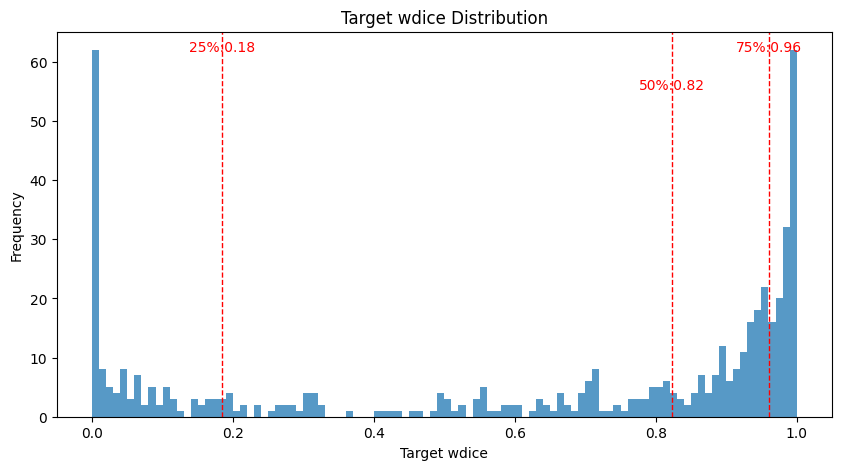

In [59]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(
    test_pred_df_full.loc[
        ~test_pred_df_full["Decoy"], "per_image_weighted_dice_metric"
    ],
    "Target wdice",
    save_dir=None,
)

25%: 0.00
50%: 1.00
75%: 1.00


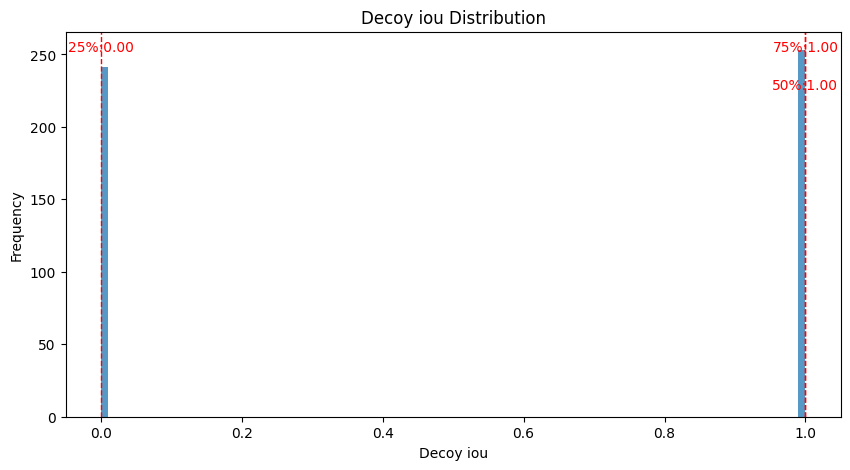

In [62]:
plot_per_image_metric_distr(
    test_pred_df_full.loc[test_pred_df_full["Decoy"], "per_image_weighted_iou_metric"],
    "Decoy iou",
    save_dir=None,
)

<Axes: xlabel='log_sum_intensity', ylabel='Density'>

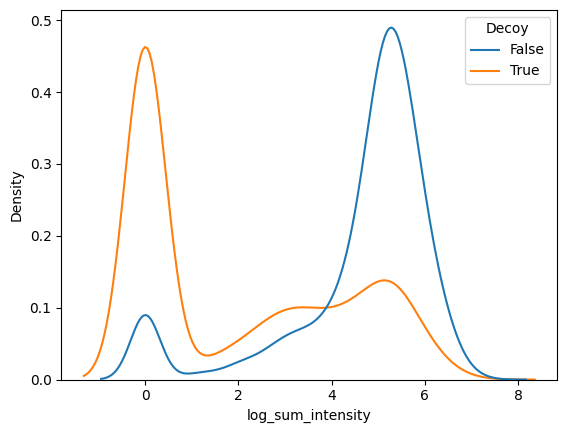

In [22]:
import seaborn as sns

test_pred_df_full["log_sum_intensity"] = np.log10(
    test_pred_df_full["sum_intensity"] + 1
)
test_pred_df_full["out_score_scaled"] = (
    test_pred_df_full["out_score"] - test_pred_df_full["out_score"].min()
) / (test_pred_df_full["out_score"].max() - test_pred_df_full["out_score"].min())
sns.kdeplot(
    # data=test_pred_df_full.loc[test_pred_df_full["log_sum_intensity"] > -10],
    data=test_pred_df_full,
    x="log_sum_intensity",
    hue="Decoy",
    common_norm=False,
)

In [25]:
test_pred_df_full.loc[
    test_pred_df_full["log_sum_intensity"] > 4, "Decoy"
].value_counts()

False    2744
True      959
Name: Decoy, dtype: int64

In [ ]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(
    test_pred_df_full,
    "sum_intensity",
    "Decoy",
    "log_sum_intensity",
    "log10(sum_intensity + 1)",
    "Decoy",
    "log10(sum_intensity + 1) distribution",
    "log10(sum_intensity + 1) distribution",
    "log10(sum_intensity + 1) distribution",
)

In [17]:
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

'plot_per_image_metric_distr'

# Outdated

In [5]:
import torch
from peak_detection_2d.model.build_model import build_model
from peak_detection_2d.dataset.dataset import (
    MultiHDF5_MaskDataset,
    build_transformation,
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


h5_path = os.path.join(
    cfg.DATASET.RAW_DATA_PATH,
    cfg.DATASET.ACTIVATION_PATH,
    cfg.DATASET.MODEL_DATA_PATH,
)

# Load data
hdf5_files = [
    os.path.join(h5_path, f) for f in os.listdir(h5_path) if f.endswith(".h5")
]

transformation, cfg.DATASET = build_transformation(cfg.DATASET)

if cfg.DATASET.INPUT_CHANNELS == ["log"]:
    cfg.ONLY_LOG_CHANNEL = True
cfg.MODEL.PARAMS.IN_CHANNELS = cfg.DATASET.N_CHANNEL
logging.info("Dataset channels: %d", cfg.MODEL.PARAMS.IN_CHANNELS)

# Create the dataset
dataset = MultiHDF5_MaskDataset(
    hdf5_files, transforms=transformation, use_hint_channel=cfg.DATASET.USE_HINT_CHANNEL
)
# Split the dataset into training and testing sets
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=cfg.DATASET.TRAIN_VAL_SIZE, seed=cfg.DATASET.RANDOM_STATE
)
train_dataset, val_dataset = train_val_dataset.split_dataset(
    train_ratio=cfg.DATASET.TRAIN_SIZE, seed=cfg.DATASET.RANDOM_STATE
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=cfg.DATASET.TRAIN_BATCH_SIZE, shuffle=False
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False
)
logging.info("Train dataset size: %d", len(train_dataset))
logging.info("Validation dataset size: %d", len(val_dataset))
logging.info("Test dataset size: %d", len(test_dataset))

# Build model using config dict node
model = build_model(cfg.MODEL)
model.to(DEVICE)

checkpoint = torch.load(best_model_path, map_location=DEVICE)

model.load_state_dict(checkpoint["model_state_dict"])
logging.info("Model loaded from %s", best_model_path)

2024-07-10 06:41:53,741 - numexpr.utils - INFO - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-07-10 06:41:53,743 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-07-10 06:41:58,540 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Padding object at 0x7f63ede91f60>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f632e77ad40>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f6318e7f220>]
2024-07-10 06:41:58,541 - root - INFO - Dataset channels: 3
2024-07-10 06:41:58,594 - root - INFO - Train dataset size: 25133
2024-07-10 06:41:58,594 - root - INFO - Validation dataset size: 2793
2024-07-10 06:41:58,595 - root - INFO - Test dataset size: 3103


UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32,

<All keys matched successfully>

2024-07-10 06:42:20,335 - root - INFO - Model loaded from /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_hint_channel_exp_log_lr001_wdice1_dh5/model_backups/bst_model_0.7877.pt


# Evaluate on test set

In [6]:
%autoreload 2
from peak_detection_2d.train import testset_eval
group_by
results_dir = os.path.join(peak_selection_dir, "results")
testset_eval(
    best_model_path,
    cfg.MODEL,
    test_dataset,
    test_dataloader,
    results_dir,
    DEVICE,
    exp=cfg.DATASET.ONLY_LOG_CHANNEL,
    threshold=cfg.MODEL.EVALUATION.THRESHOLD,
)

KeyboardInterrupt: 

## Pixel-wise evaluation

In [7]:
from peak_detection_2d.model.seg_model import inference_flatten_output


out_score_list, out_final_list, label_list, out_list = inference_flatten_output(
    data_loader=test_dataloader, model=model, device=DEVICE, get_labels=True
)
out_score_list = abs(0.5 - np.array(out_score_list)) * 2

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a CuDNNError: cuDNN error: CUDNN_STATUS_ALLOC_FAILED
Exception raised from run_conv_plan at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:374 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f96ce178897 in /cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xe1640b (0x7f966d5fb40b in /cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so)
frame #2: <unknown function> + 0x108f133 (0x7f966d874133 in /cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so)
frame #3: <unknown function> + 0x1091043 (0x7f966d876043 in /cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown 

RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1712608839953/work/c10/cuda/CUDACachingAllocator.cpp":813, please report a bug to PyTorch. 

In [8]:
%autoreload 2
from peak_detection_2d.loss.reliability_diagram import compute_calibration

calib_dict = compute_calibration(
    true_labels=label_list,
    pred_labels=out_final_list,
    confidences=out_score_list,
    num_bins=10,
)

In [9]:
np.save(
    file=os.path.join(peak_selection_dir, "testset_label_array.npy"),
    arr=np.array(label_list),
)
np.save(
    file=os.path.join(peak_selection_dir, "testset_pred_array.npy"),
    arr=np.array(out_final_list),
)
np.save(
    file=os.path.join(peak_selection_dir, "testset_score_array.npy"),
    arr=np.array(out_score_list),
)
np.save(
    file=os.path.join(peak_selection_dir, "testset_out_array.npy"),
    arr=np.array(out_list),
)

In [11]:
calib_dict

{'accuracies': array([0.53418298, 0.9592873 , 0.65906167, 0.72069577, 0.773462  ,
        0.81672058, 0.85768202, 0.892149  , 0.92636382, 0.99838808]),
 'confidences': array([0.0502808 , 0.16567728, 0.25090867, 0.35091987, 0.45072103,
        0.55162209, 0.65221876, 0.7531597 , 0.85651952, 0.99462962]),
 'counts': array([   339672,   3549924,    385492,    437326,    481566,    554323,
           698963,    966361,   1689998, 197444466]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.9931569205352763,
 'avg_confidence': 0.9702029676014617,
 'expected_calibration_error': 0.022953952933814515,
 'max_calibration_error': 0.7936100181842658}

: 

2024-06-27 09:02:09,388 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-27 09:02:09,391 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-27 09:02:09,413 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-27 09:02:09,415 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-06-27 09:02:09,417 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='norm

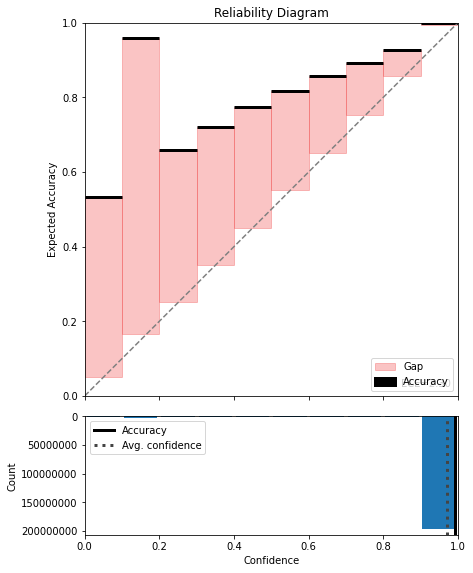

In [10]:
from peak_detection_2d.loss.reliability_diagram import _reliability_diagram_combined

_reliability_diagram_combined(
    calib_dict,
    # num_bins=10,
    draw_ece=True,
    draw_bin_importance=False,
    draw_averages=True,
    title="Reliability Diagram",
    figsize=(6, 6),
    dpi=72,
    return_fig=False,
)

In [6]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

# out_score_list_corrected = abs(0.5 - out_score_list) * 2
X_train, X_test, y_train, y_test = train_test_split(
    out, label, test_size=0.95, random_state=42
)
iso_reg = IsotonicRegression().fit(X_train, y_train)
# y_pred = iso_reg.predict(X_test)

In [10]:
y_pred = iso_reg.predict(out)

In [12]:
y_pred_corrected = abs(0.5 - y_pred) * 2

/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/loss/reliability_diagram.py:235: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


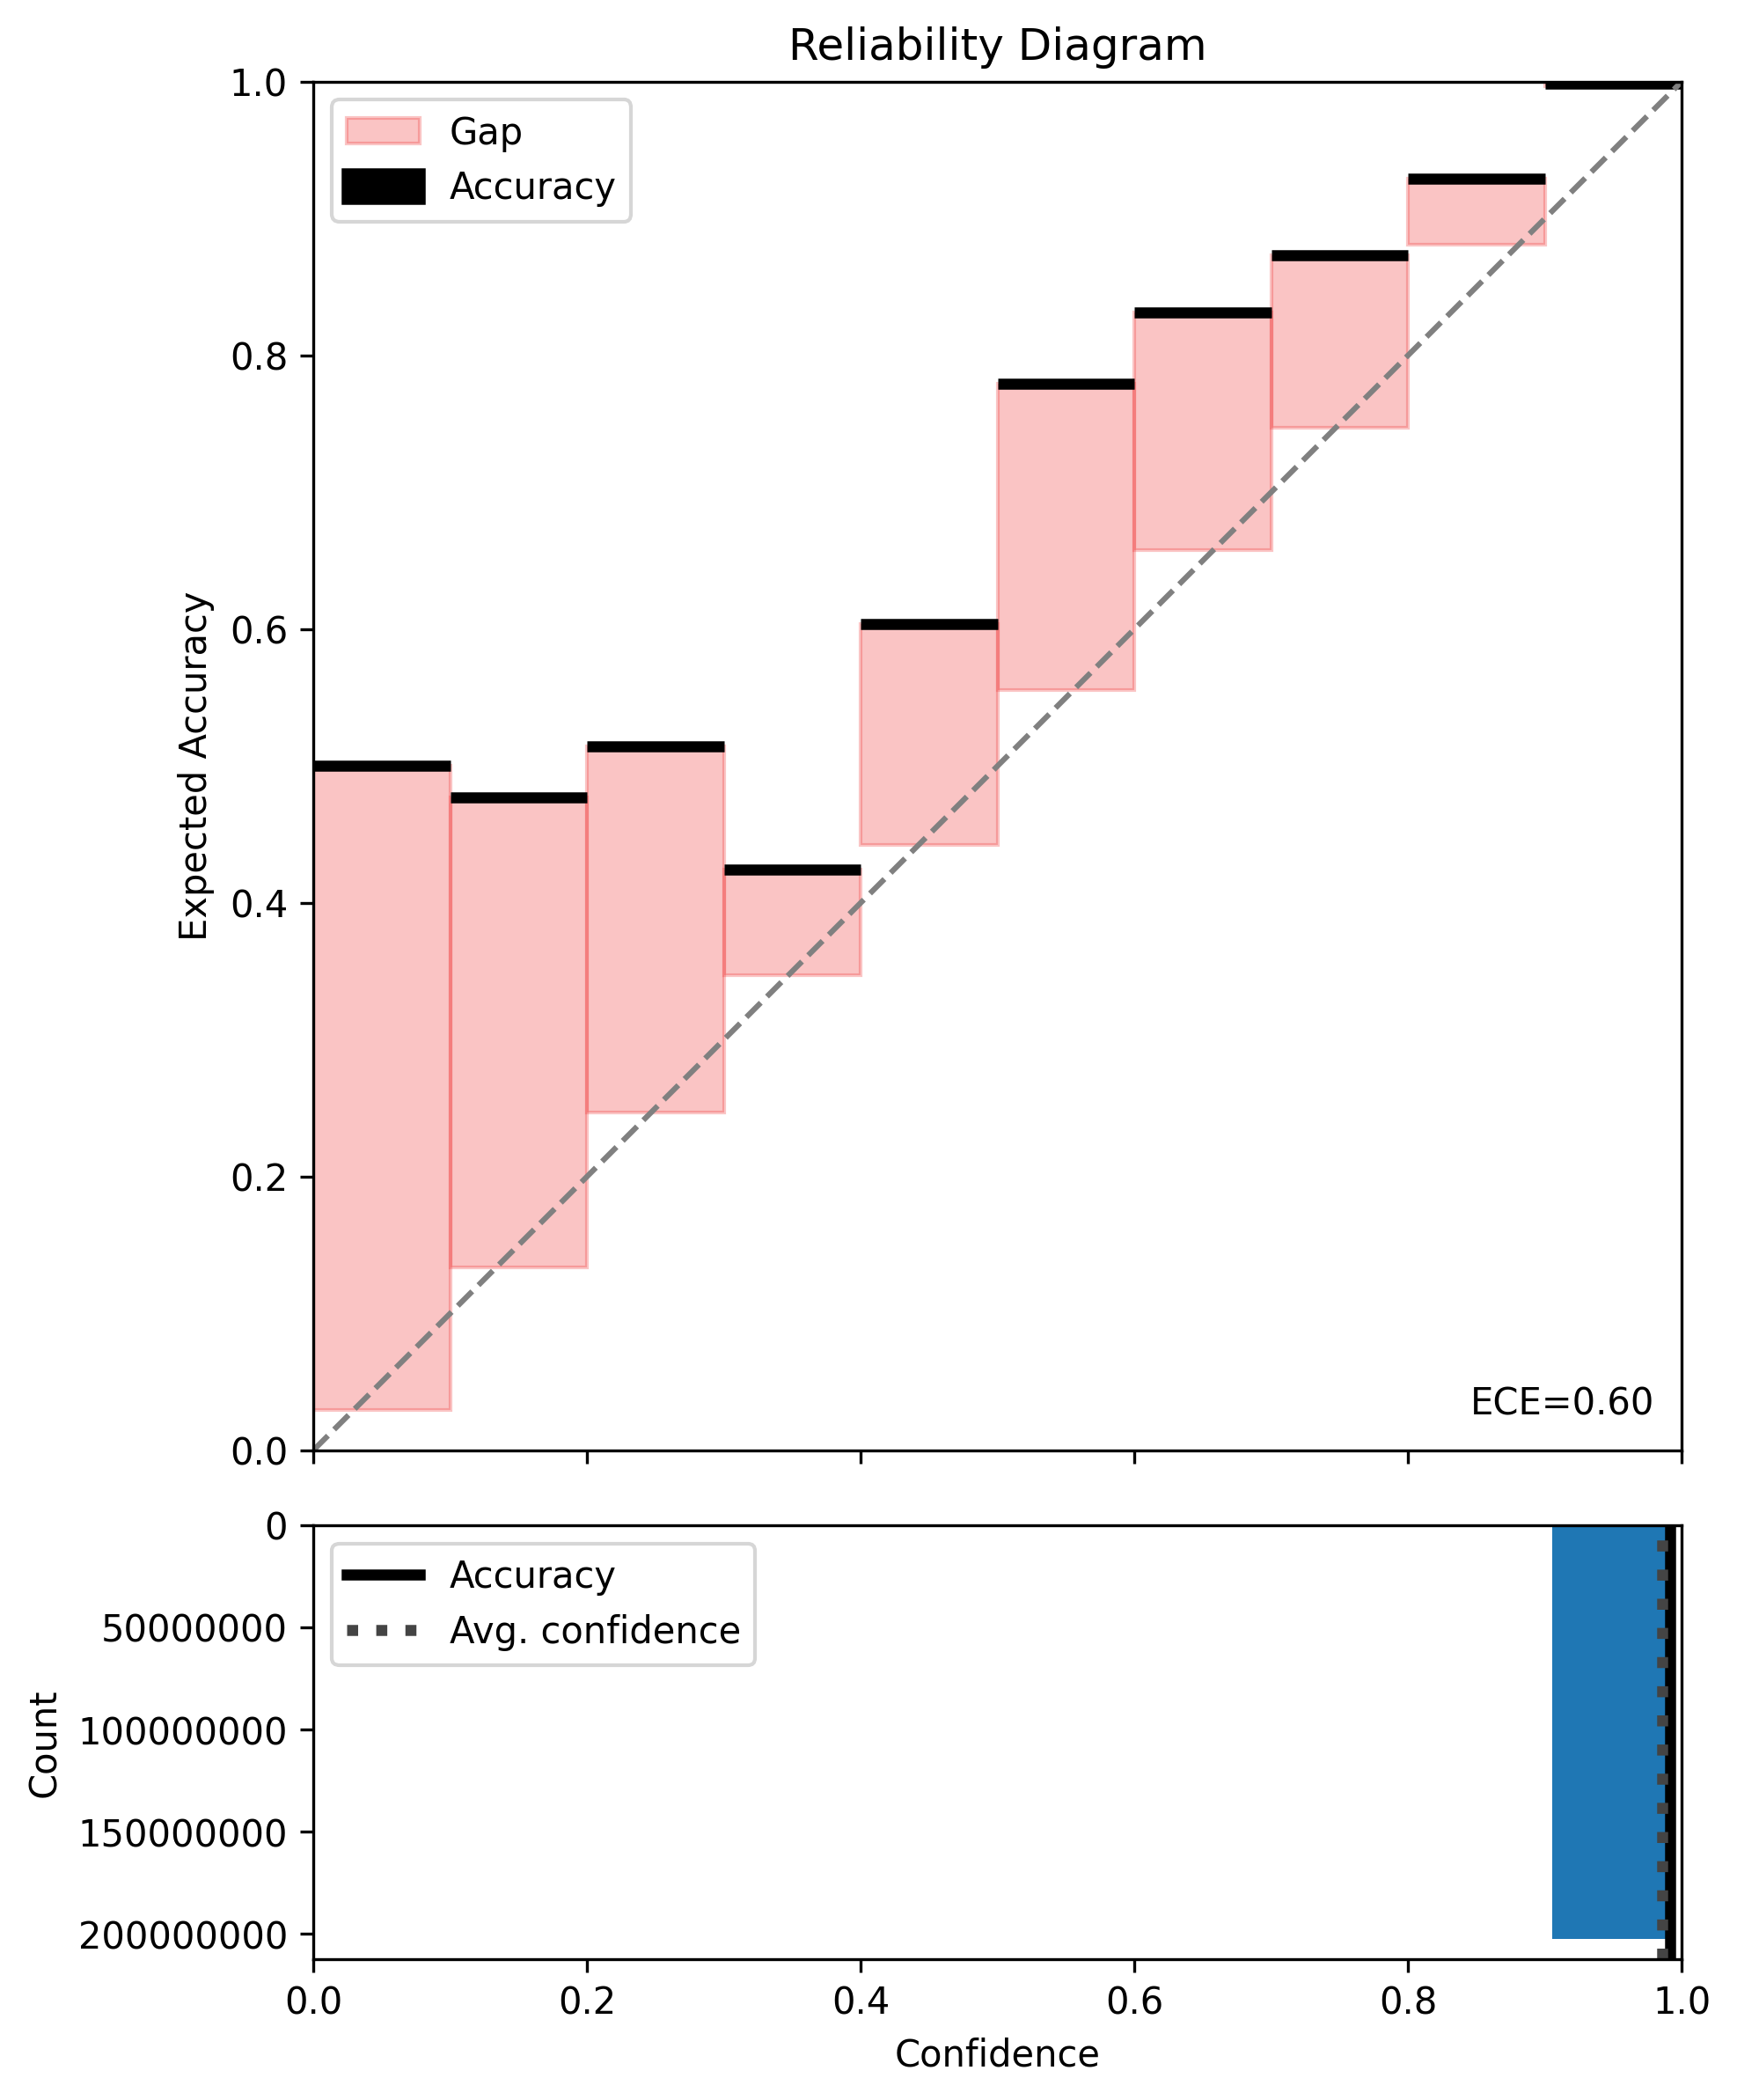

In [14]:
from peak_detection_2d.loss.reliability_diagram import reliability_diagram

reliability_diagram(
    true_labels=label,
    pred_labels=pred,
    confidences=y_pred_corrected,
    num_bins=10,
    return_fig=False,
    dpi=300,
)

/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/loss/reliability_diagram.py:235: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)
2024-06-17 09:12:05,248 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-06-17 09:12:05,249 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-06-17 09:12:05,250 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant

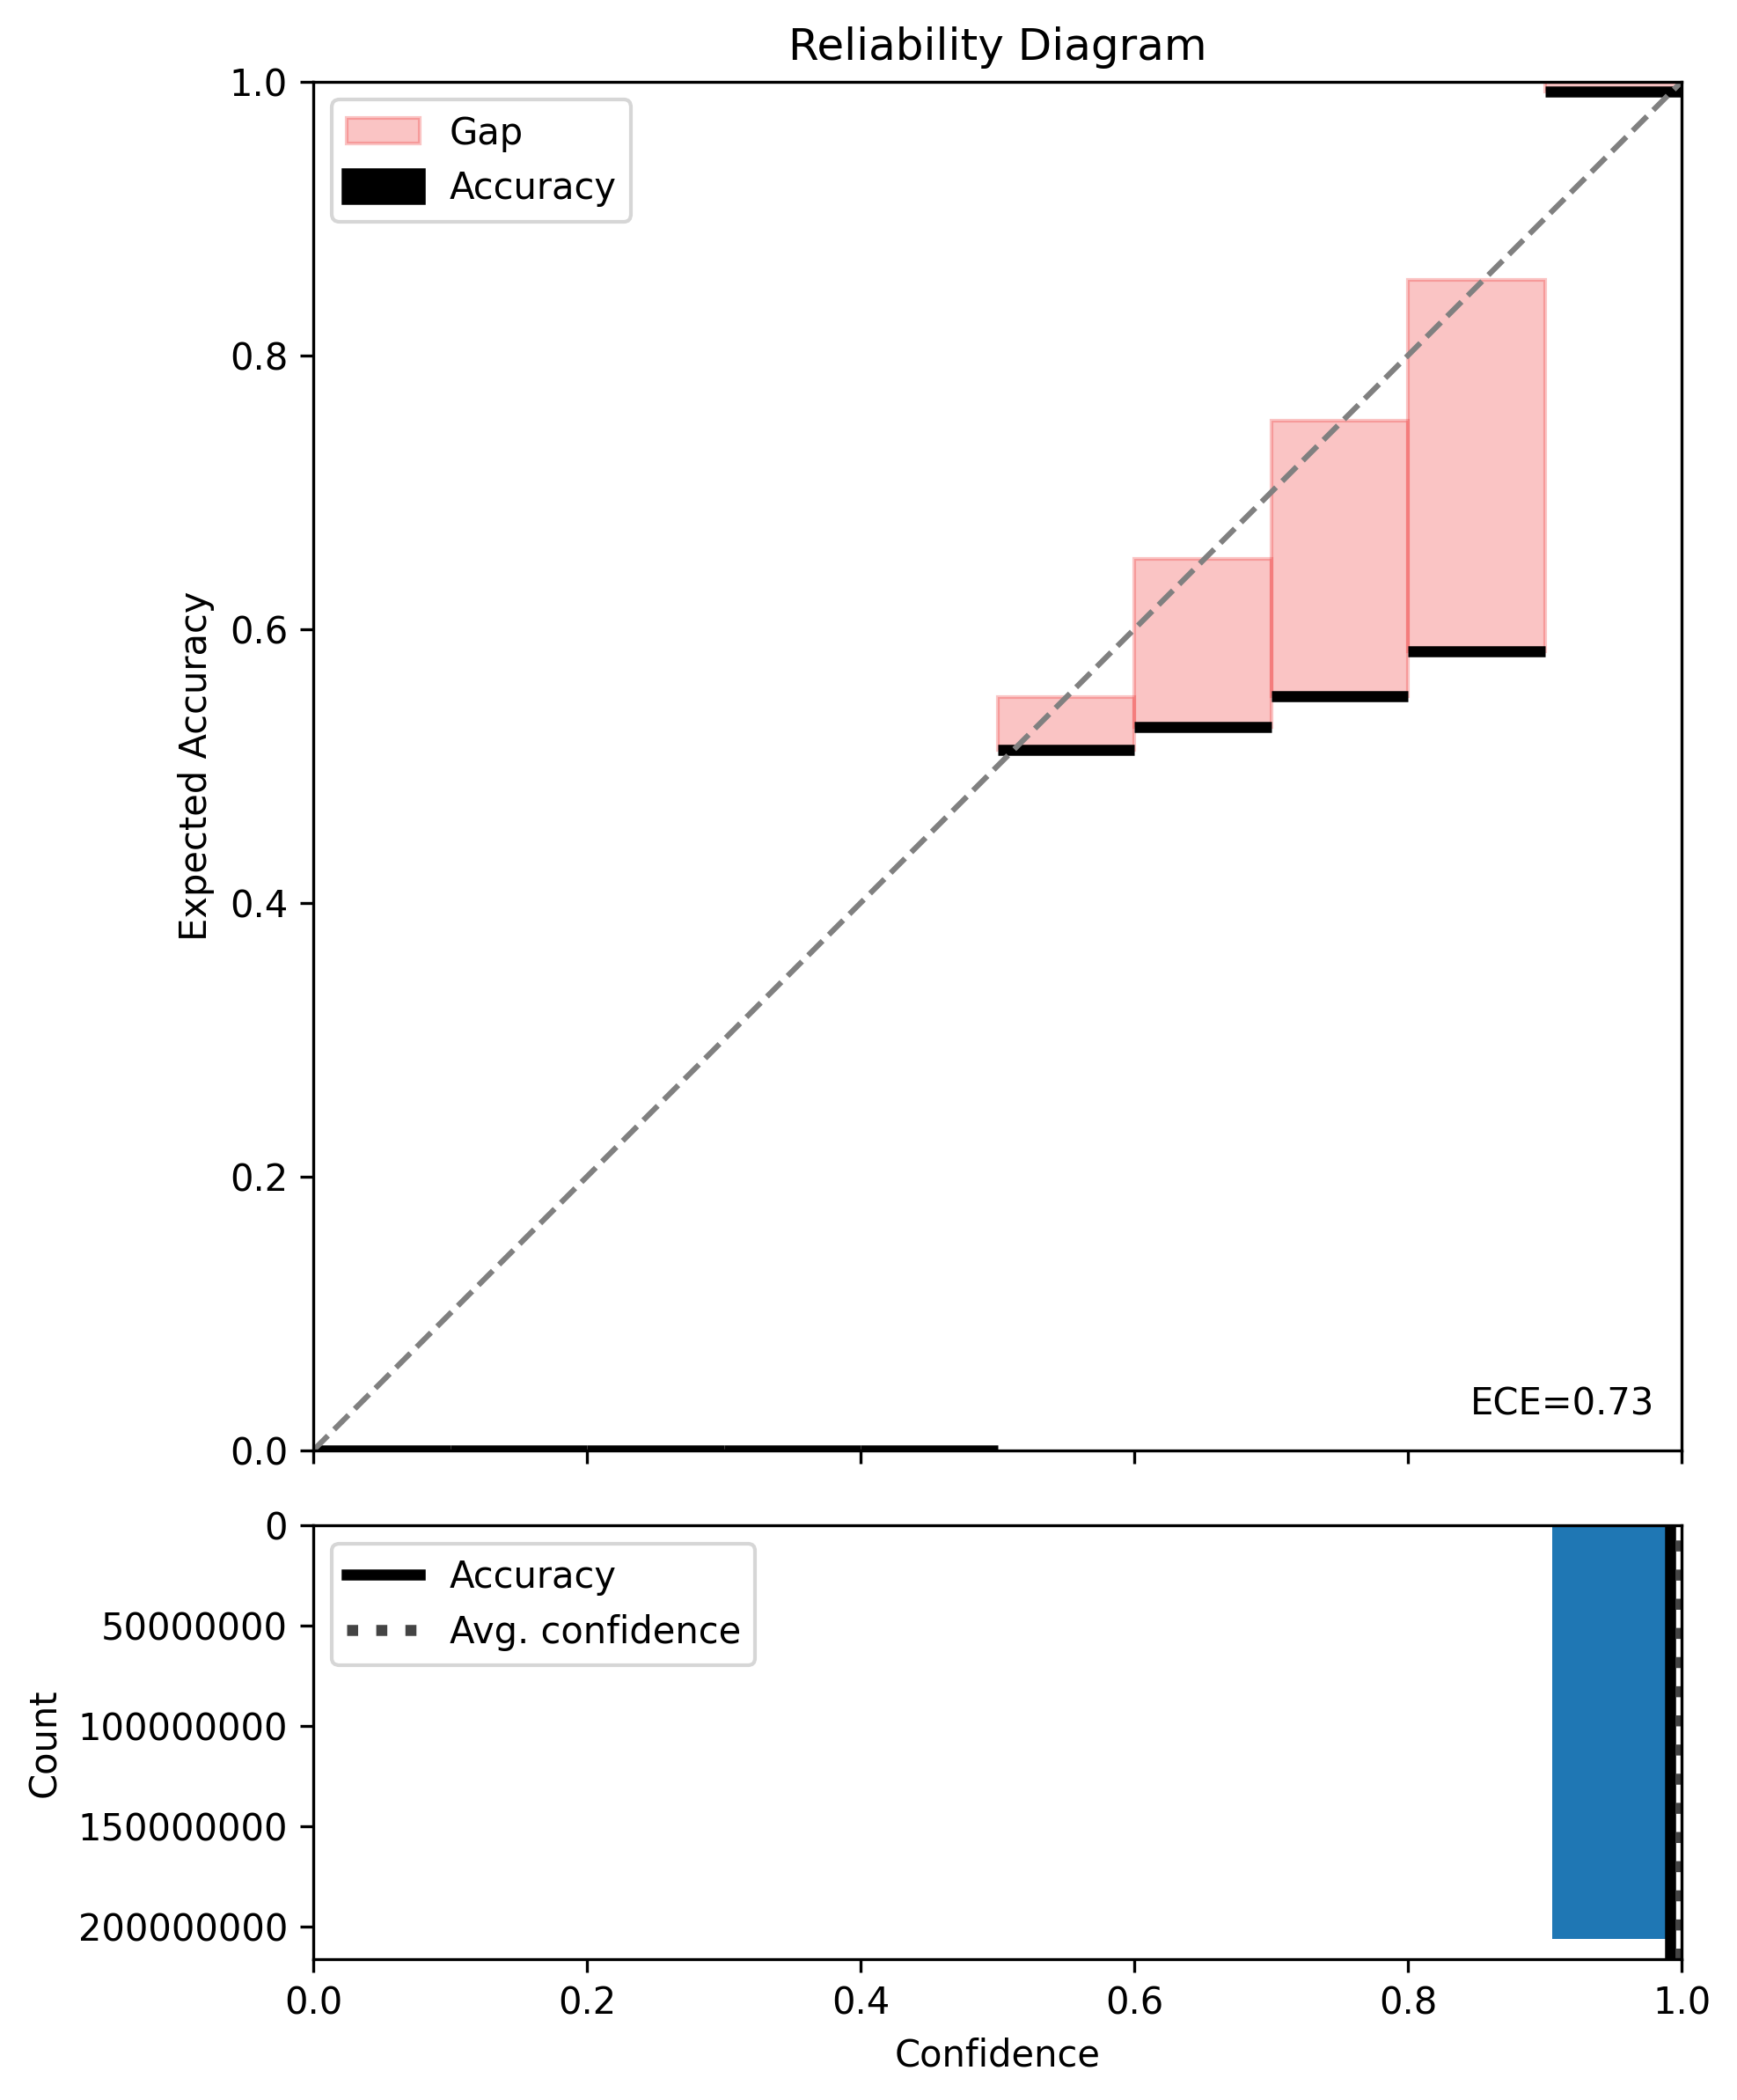

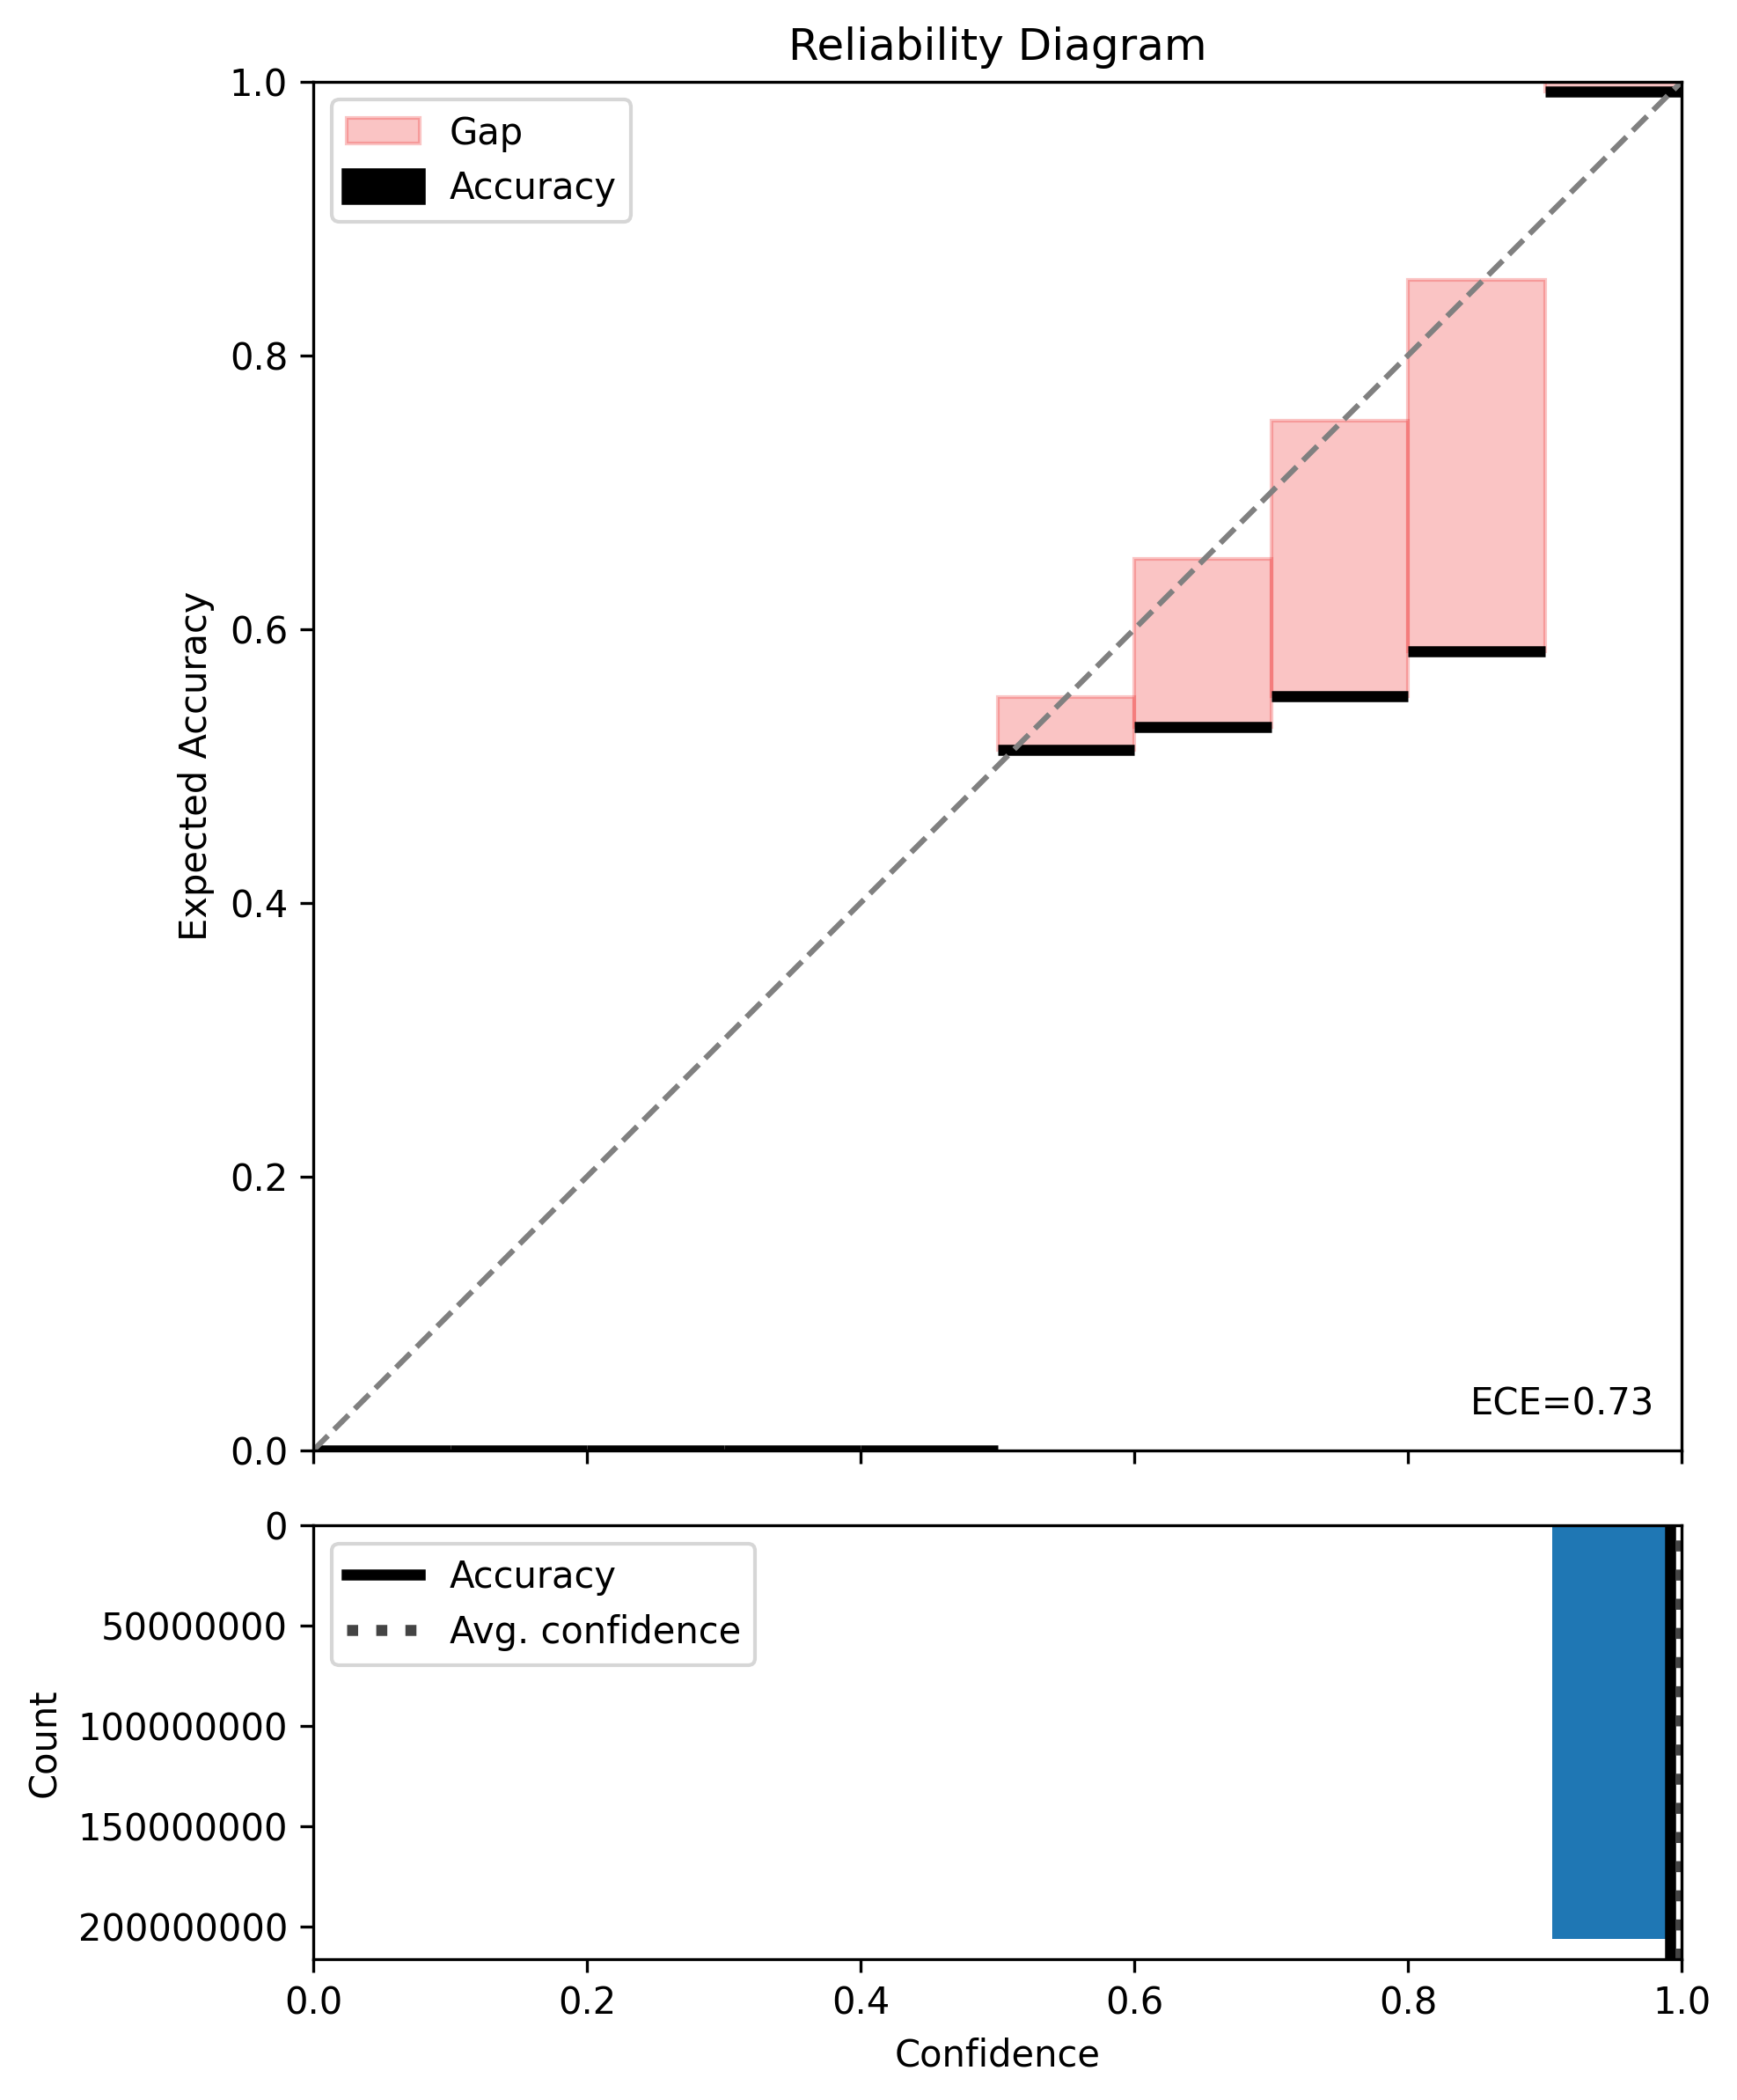

In [15]:
from peak_detection_2d.loss.reliability_diagram import reliability_diagram

reliability_diagram(
    true_labels=label_list,
    pred_labels=out_final_list,
    confidences=out_score_list,
    num_bins=10,
    return_fig=False,
    dpi=300,
)

## Image wise evaluation

### label intensity of low wiou peptide samples

In [7]:
from peak_detection_2d.model.conf_model import inference_and_sum_intensity

test_pred_df = inference_and_sum_intensity(
    data_loader=test_dataloader,
    model=model,
    device=DEVICE,
    calc_score="sigmoid",
    plot_calib_score_distribution=True,
    result_dir=os.path.join(peak_selection_dir, "results"),
)
test_pred_df.to_csv(
    os.path.join(peak_selection_dir, "results", "test_pred_df.csv"), index=False
)

<Axes: xlabel='out_score', ylabel='wiou'>

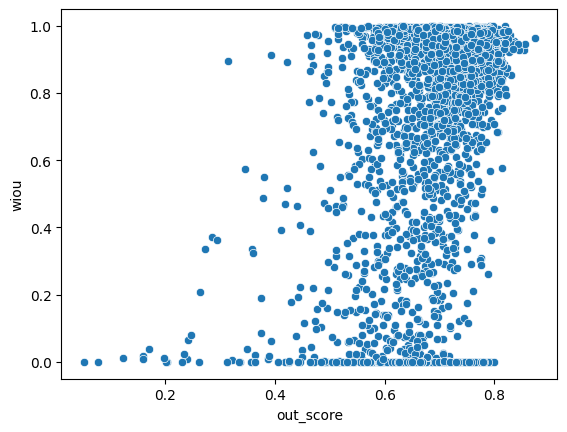

In [8]:
import seaborn as sns

sns.scatterplot(x="out_score", y="wiou", data=test_pred_df)

<Axes: >

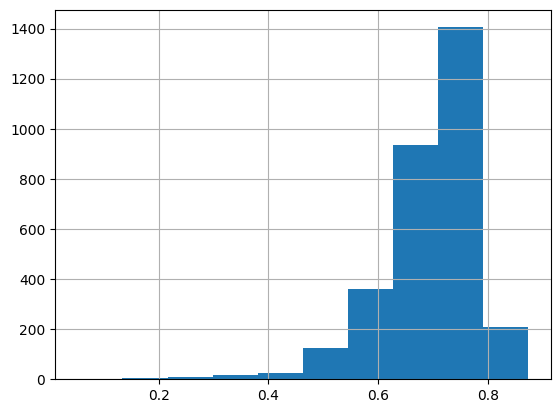

In [9]:
test_pred_df["out_score"].hist()

2024-07-10 06:44:50,389 - peak_detection_2d.loss.custom_loss - INFO - dice loss shape: torch.Size([1])
2024-07-10 06:44:50,411 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-07-10 06:44:50,458 - peak_detection_2d.utils - INFO - Masked area 120.0
2024-07-10 06:44:50,460 - peak_detection_2d.utils - INFO - Masked intensity sum 975.96
2024-07-10 06:44:50,462 - peak_detection_2d.utils - INFO - Pred masked intensity sum 359.08
2024-07-10 06:44:50,463 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


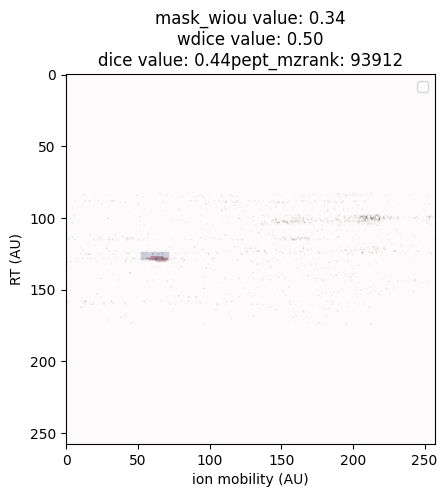

In [10]:
from peak_detection_2d.utils import plot_sample_predictions

plot_sample_predictions(
    test_dataset,
    model=model,
    device=DEVICE,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    sample_indices=[2162],
    save_dir=None,
)

## Correlation of sum_intensitys

In [43]:
maxquant_merge = pd.read_pickle(
    os.path.join(result_dir, "maxquant_result_merged_cleaned.pkl")
)
maxquant_dict = pd.read_pickle(os.path.join(result_dir, "maxquant_result_ref.pkl"))
maxquant_dict.columns
other_cols = [
    "mz_rank",
    "Sequence",
    "Proteins",
    "Leading proteins",
    "Leading razor protein",
    "Gene names",
    "Protein names",
    "Protein group IDs",
]
maxquant_merge_aug = pd.merge(
    maxquant_merge,
    maxquant_dict[other_cols],
    on="mz_rank",
    how="left",
)

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Fraction', 'Experiment',
       'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/

In [85]:
msms = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/brain/txt_ssDDA_LFQ_noMBR/evidence_fresh1.txt", sep="\t"
)

/tmp/ipykernel_14615/1746470786.py:1: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  msms = pd.read_csv(


In [87]:
msms.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Mat

In [77]:
msms1 = msms.loc[msms["Raw file"] == "ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921"]
msms1.to_csv(
    "/cmnfs/proj/ORIGINS/data/brain/txt_ssDDA_LFQ_noMBR/msms_P064428_Fresh1.txt"
)

In [81]:
msms1["Scan number"].nunique()

37448

In [79]:
msms1.Frame.nunique()

AttributeError: 'DataFrame' object has no attribute 'Frame'

In [75]:
msms1.Precursor.nunique()

157769

In [74]:
msms1.ScanNumBegin.describe()
msms1.ScanNumEnd.describe()

count    263789.000000
mean        480.872713
std         252.629633
min          41.000000
25%         264.000000
50%         484.000000
75%         698.000000
max         912.000000
Name: ScanNumBegin, dtype: float64

count    263789.000000
mean        498.872713
std         252.629633
min          59.000000
25%         282.000000
50%         502.000000
75%         716.000000
max         930.000000
Name: ScanNumEnd, dtype: float64

<Axes: >

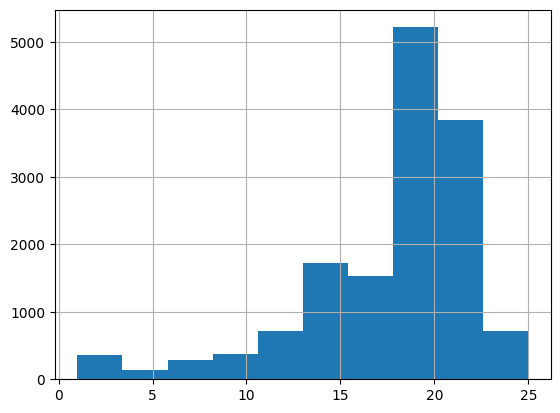

In [70]:
msms1.groupby("Frame").size().hist()

In [ ]:
msms.columns

2024-07-10 10:57:57,688 - result_analysis.result_analysis - INFO - Reference shape: (31029, 39)
2024-07-10 10:57:57,708 - result_analysis.result_analysis - INFO - Group by Leading razor protein
2024-07-10 10:57:57,716 - result_analysis.result_analysis - INFO - Grouped dataframe columns Index(['ref_col', 'inf_col'], dtype='object')


Data:  ref_col_log inf_col_log , slope =  0.861 , intercept =  0.287 , PearsonR =  0.864 , SpearmanR =  0.859


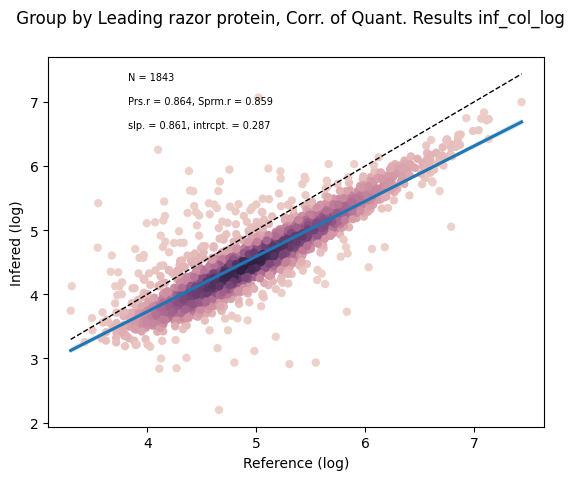

In [55]:
%autoreload 2
from result_analysis.result_analysis import SBSResult
import pandas as pd

try:
    test_pred_df = pd.read_csv(
        os.path.join(peak_selection_dir, "results", "test_pred_df.csv")
    )
except FileNotFoundError:
    test_pred_df = inference_and_sum_intensity(
        data_loader=test_dataloader,
        model=model,
        device=DEVICE,
        calc_score="sigmoid",
        plot_calib_score_distribution=True,
        result_dir=os.path.join(peak_selection_dir, "results"),
    )
    test_pred_df.to_csv(
        os.path.join(peak_selection_dir, "results", "test_pred_df.csv"), index=False
    )
# maxquant_merge = pd.read_pickle(
#     os.path.join(result_dir, "maxquant_result_ref.pkl")
# )
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_merge_aug,
    maxquant_merge_df=maxquant_merge_aug,
    maxquant_exp_df=None,
    sum_raw=test_pred_df,
    # sum_raw=test_pred_df,
    # sum_gaussian=train_label_df,
    ims=True,
    other_cols=other_cols
)
sbs_ims_result.plot_intensity_corr(
    ref_col="Intensity",
    inf_col="sum_intensity",
    contour=False,
    group_by="Leading razor protein"
    # save_dir=os.path.join(peak_selection_dir, "results"),
)

In [9]:
sbs_ims_result.ref_exp_df_inner.columns

Index(['Modified sequence', 'Charge', 'predicted_RT', 'm/z', 'Mass', 'Length',
       'id', 'RT_search_left', 'RT_search_right', 'RT_search_center',
       'mz_rank', 'Reverse', 'mobility_values', 'mobility_values_index',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Calibrated retention time', 'Retention time', 'Intensity',
       'Ion mobility index', 'Ion mobility length', '1/K0', '1/K0 length',
       'Calibrated 1/K0', 'CCS', 'Calibrated CCS', 'CCS length', '_merge',
       'RT_overlap', 'IM_search_left', 'IM_search_right', 'IM_overlap',
       'sum_intensity', 'pept_mz_rank', 'out_score', 'wiou',
       'label_sum_intensity'],
      dtype='object')

## Samples with low IoU

<Axes: xlabel='log_label_intensity', ylabel='log_pred_intensity'>

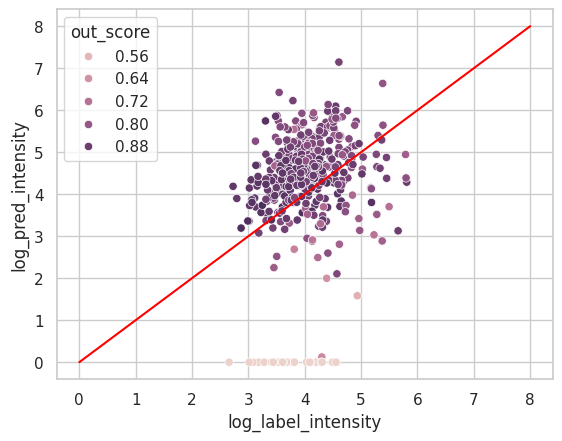

In [82]:
from matplotlib import cm
from pyparsing import col


# set grid in the background
sns.set(style="whitegrid")
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_label_intensity",
    y="log_pred_intensity",
    hue="out_score",
    hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)
plt.plot([0, 8], [0, 8], color="red")

<Axes: xlabel='log_pred_intensity', ylabel='out_score'>

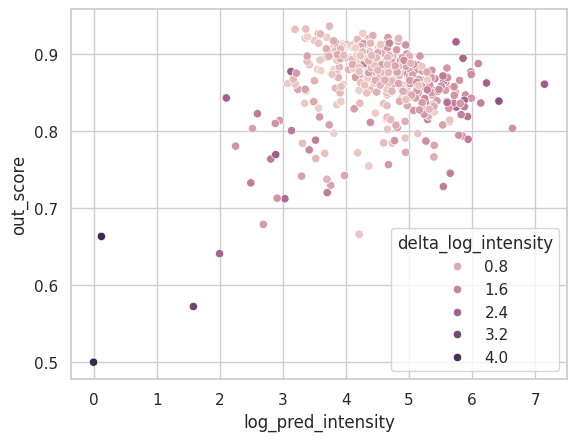

In [91]:
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_pred_intensity",
    y="out_score",
    hue="delta_log_intensity",
    # hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)

<Axes: xlabel='losses', ylabel='out_score'>

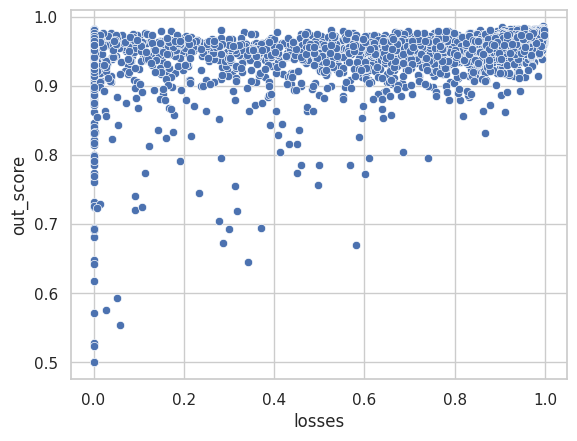

In [111]:
# Evaluating miscalibration
sns.scatterplot(
    # data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    data=test_all_df,
    x="losses",
    y="out_score",
    # hue="delta_log_intensity",
    # hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)

In [ ]:
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_label_intensity",
    y="log_pred_intensity",
    size="out_score",
    # color=cm.get_cmap("coolwarm"),
)

In [80]:
from peak_detection_2d.utils import plot_sample_predictions
import pandas as pd

ind_all_wiou = pd.DataFrame(ind_all_wiou)
# get indices of the top 10 worst performing images
worst_performing_images = ind_all_wiou["losses"].sort_values(ascending=True).index[:10]

# Plot sample predictions
plot_sample_predictions(
    test_dataset,
    model=model,
    sample_indices=worst_performing_images,
    # n = 10,
    # save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions_lowest_wiou"),
)

2024-06-06 16:19:17,937 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-06 16:19:17,938 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 2, 258, 258])
2024-06-06 16:19:17,964 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 258, 258])
2024-06-06 16:19:17,965 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

In [82]:
best_performing_images = (
    ind_all_wiou["losses"].sort_values(ascending=False).index[50:60]
)

# Plot sample predictions
plot_sample_predictions(
    test_dataset,
    model=bst_model,
    sample_indices=best_performing_images,
    # n = 10,
    # save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions_highest_wiou"),
)

2024-06-06 16:21:26,036 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-06 16:21:26,037 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 2, 258, 258])
2024-06-06 16:21:26,038 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 258, 258])
2024-06-06 16:21:26,039 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

In [84]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(
    ind_all_wiou["losses"], "Weighted_IoU", save_dir=peak_selection_dir
)
plot_per_image_metric_distr(
    ind_all_wdice["losses"], "Weighted_Dice", save_dir=peak_selection_dir
)

25%: 0.14
50%: 0.78
75%: 0.95
25%: 0.25
50%: 0.88
75%: 0.97


In [41]:
import gc

torch.cuda.empty_cache()
gc.collect()

31

In [20]:
%autoreload 2
from peak_detection_2d.utils import plot_sample_predictions

# Plot sample predictions
plot_sample_predictions(
    test_dataset,
    model=bst_model,
    sample_indices=[1420, 2409, 1483, 2101,  68, 3003, 2973, 2182, 2311, 2606],
    #n = 10,
    #save_dir=None,
    metric_list = ["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in = False,
    label = 'mask',
    save_dir=os.path.join(peak_selection_dir, "sample_predictions"),
)

2024-06-03 16:25:35,331 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-03 16:25:35,332 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 1, 178, 178])
2024-06-03 16:25:35,333 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 178, 178])
2024-06-03 16:25:35,334 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding